![](https://images.unsplash.com/photo-1602084551218-a28205125639?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2070&q=80)

<div class = 'alert alert-block alert-info'
     style = 'background-color:#4c1c84;
              color:#eeebf1;
              border-width:5px;
              border-color:#4c1c84;
              font-family:Comic Sans MS;
              border-radius: 50px 50px'>
    <p style = 'font-size:24px'>Exp 016</p>
    <a href = "#Config"
       style = "color:#eeebf1;
                font-size:14px">1.Config</a><br>
    <a href = "#Settings"
       style = "color:#eeebf1;
                font-size:14px">2.Settings</a><br>
    <a href = "#Data-Load"
       style = "color:#eeebf1;
                font-size:14px">3.Data Load</a><br>
    <a href = "#Pytorch-Settings"
       style = "color:#eeebf1;
                font-size:14px">4.Pytorch Settings</a><br>
    <a href = "#Training"
       style = "color:#eeebf1;
                font-size:14px">5.Training</a><br>
</div>

<p style = 'font-size:24px;
            color:#4c1c84'>
    実施したこと
</p>
    <li style = "color:#4c1c84;
                font-size:14px">過去コンペの予測ラベル</li>
    <li style = "color:#4c1c84;
                font-size:14px">fasttext</li>
    <li style = "color:#4c1c84;
                font-size:14px">SVR</li>

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Config
</h1>
<br>

In [1]:
import sys
sys.path.append("../src/utils/iterative-stratification/")

In [5]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import copy
import math
import time
import random
import string
import psutil
import pathlib
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict
from box import Box
from typing import Optional
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW
from transformers import RobertaModel, RobertaForSequenceClassification
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
from transformers import RobertaTokenizer

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning import LightningDataModule, LightningDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar

# Model
import lightgbm as lgb
from sklearn.svm import SVC
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


In [4]:
model = torch.hub.load('unitaryai/detoxify','toxic_bert')
model

Using cache found in /root/.cache/torch/hub/unitaryai_detoxify_master
Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.1-alpha/toxic_original-c1212f89.ckpt" to /root/.cache/torch/hub/checkpoints/toxic_original-c1212f89.ckpt


  0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [7]:
import torch

config = {
    "seed": 42,
    "root": "/content/drive/MyDrive/kaggle/Jigsaw/raw",
    "n_fold": 5,
    "epoch": 5,
    "max_length": 256,
    "environment": "AWS",
    "project": "Jigsaw",
    "entity": "dataskywalker",
    "exp_name": "016_exp",
    "margin": 0.5,
    "train_fold": [0, 1, 2, 3, 4],

    "trainer": {
        "gpus": 1,
        "accumulate_grad_batches": 64,
        "progress_bar_refresh_rate": 1,
        "fast_dev_run": False,
        "num_sanity_val_steps": 0,
    },

    "train_loader": {
        "batch_size": 16,
        "shuffle": False,
        "num_workers": 4,
        "pin_memory": True,
        "drop_last": False,
    },

    "valid_loader": {
        "batch_size": 4,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "test_loader": {
        "batch_size": 8,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "backbone": {
        "name": "unitary/toxic-bert",
        "output_dim": 6,
    },

    "optimizer": {
        "name": "torch.optim.AdamW",
        "params": {
            "lr": 1e-5,
        },
    },

    "scheduler": {
        "name": "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts",
        "params": {
            "T_0": 20,
            "eta_min": 0,
        },
    },

    "loss": "nn.BCEWithLogitsLoss",
}

config = Box(config)
config.tokenizer = BertTokenizer.from_pretrained(config.backbone.name)
config.model = BertForSequenceClassification.from_pretrained(config.backbone.name)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/811 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [8]:
# 個人的にAWSやKaggle環境やGoogle Colabを行ったり来たりしているのでまとめています
import os
import sys
from pathlib import Path

if config.environment == 'AWS':
    
    INPUT_DIR = Path('/mnt/work/data/kaggle/Jigsaw/')
    MODEL_DIR = Path(f'../models/{config.exp_name}/')
    OUTPUT_DIR = Path(f'../data/interim/{config.exp_name}/')
    UTIL_DIR = Path('/mnt/work/shimizu/kaggle/PetFinder/src/utils')
    
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print(f"Your environment is 'AWS'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}\nUTIL_DIR is {UTIL_DIR}")
    
    
elif config.environment == 'Kaggle':
    INPUT_DIR = Path('../input/*****')
    MODEL_DIR = Path('./')
    OUTPUT_DIR = Path('./')
    print(f"Your environment is 'Kaggle'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")

    
elif config.environment == 'Colab':
    INPUT_DIR = Path('/content/drive/MyDrive/kaggle/Jigsaw/raw')
    BASE_DIR = Path("/content/drive/MyDrive/kaggle/Jigsaw/interim")

    MODEL_DIR = BASE_DIR / f'{config.exp_name}'
    OUTPUT_DIR = BASE_DIR / f'{config.exp_name}/'

    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if not os.path.exists(INPUT_DIR):
        print('Please Mount your Google Drive.')
    else:
        print(f"Your environment is 'Colab'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")
        
else:
    print("Please choose 'AWS' or 'Kaggle' or 'Colab'.\nINPUT_DIR is not found.")

Your environment is 'AWS'.
INPUT_DIR is /mnt/work/data/kaggle/Jigsaw
MODEL_DIR is ../models/016_exp
OUTPUT_DIR is ../data/interim/016_exp
UTIL_DIR is /mnt/work/shimizu/kaggle/PetFinder/src/utils


In [9]:
# Seed固定
seed_everything(config.seed)

42

In [10]:
## 処理時間計測
@contextmanager
def timer(name:str, slack:bool=False):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield
    
    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)
    
    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec", file=sys.stderr)

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Data Load
</h1>
<br>

In [11]:
## Data Check
for dirnames, _, filenames in os.walk(INPUT_DIR):
    
    for filename in filenames:

        print(f'{dirnames}/{filename}')

/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv
/mnt/work/data/kaggle/Jigsaw/sample_submission.csv
/mnt/work/data/kaggle/Jigsaw/validation_data.csv


In [12]:
val_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/validation_data.csv")
test_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv")

In [13]:
val_df

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"
...,...,...,...
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook


In [14]:
train_df = pd.read_csv("../data/external/jigsaw1st/train.csv")
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [15]:
train_df.sort_values("severe_toxicity")

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
1183894,5563153,0.000000,"Mr. Milner, after reading your thought provoki...",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,352273,approved,0,0,0,0,0,0.000000,4,4
1183892,5563151,0.000000,"Or in other words, the road to hell is paved w...",0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,351464,approved,0,0,0,0,0,0.000000,0,4
1183891,5563149,0.000000,Tony - Russia backed many liberation struggle...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,351814,approved,0,0,0,0,0,0.000000,0,4
1183890,5563148,0.100000,"DM, how do this dude's ""articles"" make it thro...",0.000000,0.000000,0.000000,0.200000,0.000000,NaN,NaN,...,353561,approved,0,0,0,6,0,0.000000,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341396,5754942,0.973936,BURN THIS DOG RAPING WHITE NIGER ALIVE\nTIME f...,0.569070,0.596872,0.917463,0.887055,0.892268,NaN,NaN,...,365110,rejected,0,0,0,0,0,0.130321,0,1151
1679044,6180251,0.990396,DOGS----\nEAT\nSHIT\nSLEEP\nBARK\n\nNIGERS\nEA...,0.591236,0.972389,0.909964,0.971789,0.819928,NaN,NaN,...,390746,rejected,0,0,0,0,0,0.701080,0,1666
1443046,5883664,0.900000,.\n.\nIs there really a God ?\n... I once thou...,0.600000,0.800000,0.400000,0.800000,0.500000,0.0,0.0,...,373036,approved,0,0,0,2,0,0.900000,10,10
1532869,5997855,0.983501,You are murdering feckless SCUM. Your mother ...,0.644363,0.970669,0.076994,0.978002,0.739688,0.0,0.0,...,379957,rejected,0,0,0,0,0,0.857929,10,1091


In [16]:
train_df[train_df["target"]>0.]

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.000000,4,47
5,59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.009524,0,105
6,59861,0.457627,hahahahahahahahhha suck it.,0.050847,0.305085,0.000000,0.254237,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.220339,0,59
11,239579,0.440000,This is a great story. Man. I wonder if the pe...,0.000000,0.293333,0.000000,0.320000,0.0,0.0,0.0,...,26650,approved,0,0,0,1,0,0.040000,10,75
13,239583,0.600000,It's ridiculous that these guys are being call...,0.000000,0.100000,0.000000,0.600000,0.1,NaN,NaN,...,26670,approved,0,0,0,3,0,0.000000,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804863,6333950,0.200000,"Nah, I am too boring to parody. This guy Camp...",0.000000,0.000000,0.000000,0.200000,0.0,0.0,0.0,...,399210,approved,0,0,0,0,0,0.000000,4,10
1804865,6333955,0.166667,Payette's point of view is legitimate and I th...,0.000000,0.000000,0.166667,0.166667,0.0,NaN,NaN,...,399528,approved,0,0,0,0,0,0.000000,0,6
1804866,6333957,0.300000,There's no whine like Alberta whine!,0.000000,0.000000,0.000000,0.100000,0.0,NaN,NaN,...,399472,approved,0,0,0,0,0,0.200000,0,10
1804867,6333963,0.200000,"If Alberta had given them nothing, you'd STILL...",0.000000,0.000000,0.000000,0.200000,0.0,NaN,NaN,...,399472,approved,0,0,0,0,0,0.000000,0,5


In [17]:
inputs = config.tokenizer.encode_plus(
    train_df.loc[1532869, "comment_text"],
    return_tensors="pt",
    truncation=True,
    padding=True
)
outputs = config.model(**inputs)[0]
outputs = torch.sigmoid(outputs).detach().numpy()
outputs

array([[0.9975787 , 0.6898789 , 0.9811094 , 0.64655876, 0.94840175,
        0.14950171]], dtype=float32)

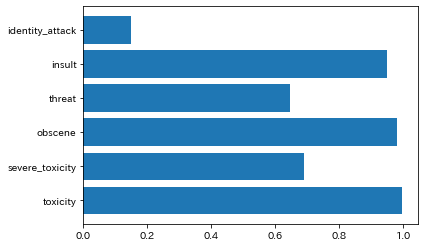

In [18]:
plt.barh(width=outputs[0, :7],
         y=["toxicity",
           "severe_toxicity",
           "obscene",
           "threat",
           "insult",
           "identity_attack",
          ])
plt.show()

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Previous Toxic Feature Label
</h1>
<br>

In [19]:
def make_feature(df:pd.DataFrame, col:str) -> pd.DataFrame:
    
    '''
    Jigsaw Unintended Bias in Toxicity Classificationコンペで学習されたモデルからの予測ラベル
    '''
    
    text_list = df[col].tolist()
    feature = []
    
    for text in tqdm(text_list, total=len(text_list)):
        inputs = config.tokenizer.encode_plus(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True
        )
        outputs = config.model(**inputs)[0]
        outputs = torch.sigmoid(outputs).detach().numpy()
        feature.append(outputs[0])
        
    feature_cols = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack"]
    feature_df = pd.DataFrame(feature, cols=feature_cols)
    feature_df = pd.concat([df[[col]], feature_df], axis=1)
    
    return feature_df

In [20]:
with timer("make feature label"):
    train_feature_df = make_feature(train_df[train_df["target"]>0.].reset_index(drop=True),
                                    "comment_text")

<< make feature label >> Start


  0%|          | 0/540110 [00:00<?, ?it/s]

TypeError: __init__() got an unexpected keyword argument 'cols'

In [ ]:
train_feature_df.to_csv(OUTPUT_DIR/f"train_features.csv", index=False)

In [ ]:
train_feature_df